In [1]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import time
import numpy as np
import math

dataset_root_dir = './BSDS300/images/'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

cuda:0


In [2]:
# 返回加噪声和原图片
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=10):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')   
        # 随机裁剪
        #i = np.random.randint(clean.size[0] - self.image_size[0])
        #j = np.random.randint(clean.size[1] - self.image_size[1])
        i=0
        j=0
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # 转换张量
            tv.transforms.ToTensor(),
            # [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [3]:
# 画图
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [4]:
# 导入训练集和测试集
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))


test_set1 = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320),sigma=30)
test_set2 = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320),sigma=50)

image size is torch.Size([3, 320, 320]).


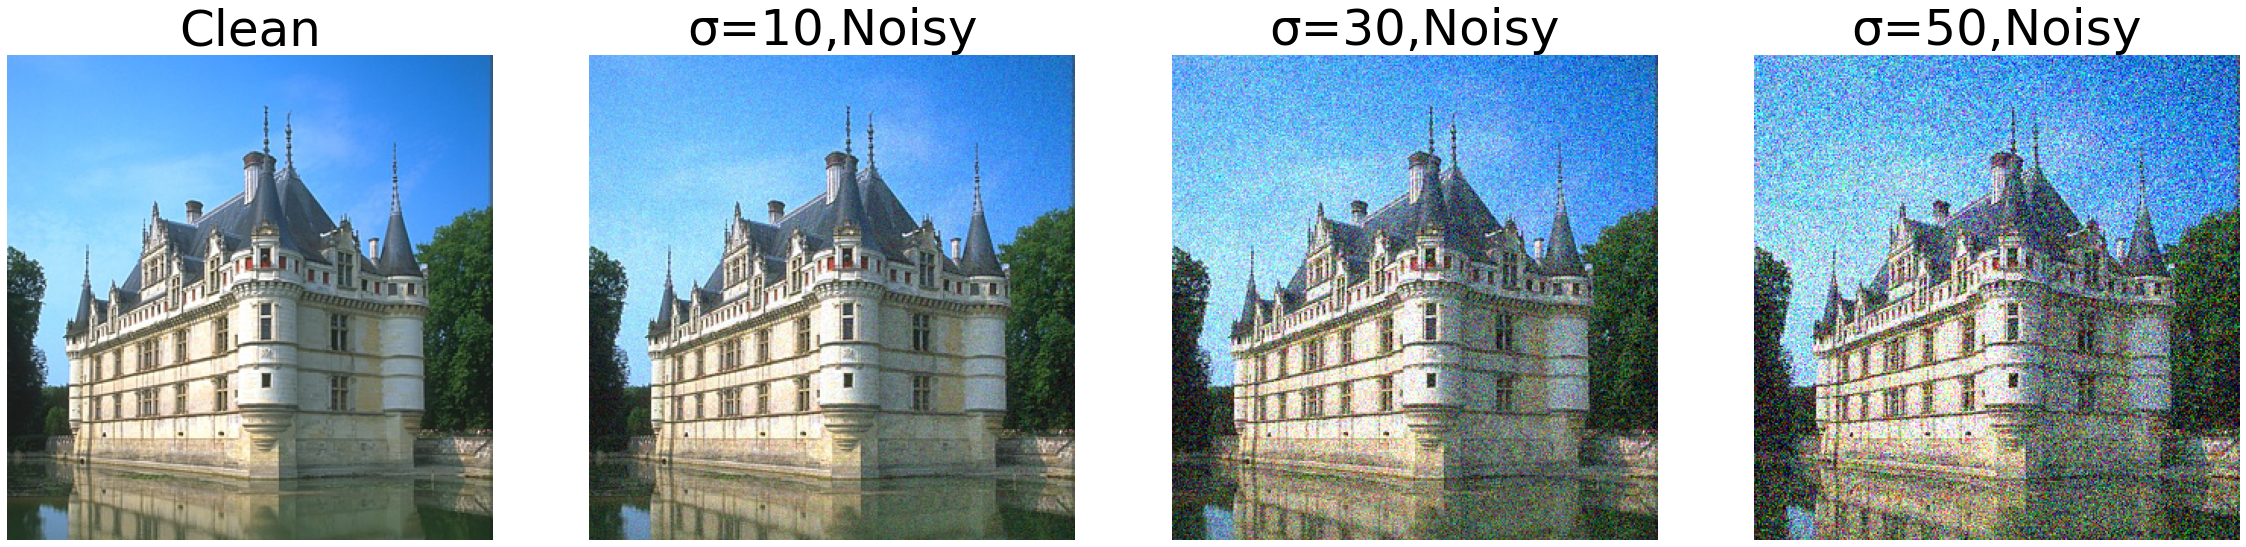

In [5]:
# 展示加噪之后的图像和原图像
x = test_set[2]
fig, axes = plt.subplots(ncols=4,figsize=(40, 64))
myimshow(x[0], ax=axes[1])
axes[1].set_title('σ=10,Noisy',fontdict={'size': 50})
myimshow(x[1], ax=axes[0])
axes[0].set_title('Clean',fontdict={'size': 50})
x = test_set1[2]
myimshow(x[0], ax=axes[2])
axes[2].set_title('σ=30,Noisy',fontdict={'size': 50})
x = test_set2[2]
myimshow(x[0], ax=axes[3])
axes[3].set_title('σ=50,Noisy',fontdict={'size': 50})

print(f'image size is {x[0].shape}.')

In [6]:
class DUDnCNN(nn.Module):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            
        y = self.conv[D+1](h) + x
        return y

In [7]:
model = DUDnCNN(6).to(device)
torch.save(model, './model_para.pth')

In [8]:
range(3)

range(0, 3)

In [9]:
for i in range(2,4):
    print(i)

2
3
